# Assessment for Advanced Data Science

## Christian Cabrera, Radzim Sendyka, Carl Henrik Ek and Neil D. Lawrence

### 6th November 2023



Welcome to the course assessment for the Advanced Data Science unit. In this assessment you will build a prediction system for UK house prices.

Your prediction system will be based on data from the UK Price Paid data available [here](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). By combining this data with the UK Office for National Statistics data on the latitude/longitude of postcodes (available [here](https://www.getthedata.com/open-postcode-geo)) you will have a record of house prices and their approximate latitude/longitude. Due to the size of these data you will use a relational database to handle them.  

To make predictions of the house price you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will use the techniques you have learnt in the course to indentify and incorporate useful features for house price prediction.



Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (<https://github.com/lawrennd/fynesse_template>) for structuring your code.

Remember the notebook you create should *tell a story*, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template)

The maximum total mark for this assessment is 20. That mark is split into Three Questions below, each worth 5 marks each. Then a final 5 marks will be given for the quality, structure and reusability of the code and analysis you produce giving 20 marks in total. At the end, we would like to know your experience using LLMs in this assignment.

### Important Note:

*Some tasks in this assignment require you to develop skills for searching for multiple solutions and trying different things. This environment recreates industrial data science and software engineering problems. There is no one right answer.*


### Useful Links

You may find some of the following links useful when building your system.

University instuctions on Security and Privacy with AWS.

https://help.uis.cam.ac.uk/service/network-services/hosting-services/AWS/aws-security-privacy

Security Rules in AWS

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_VPC.Scenarios.html#USER_VPC.Scenario4

### Installing Your Library

One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.

You should base your module on the template repository given by the Fynesse template repository. That should make it `pip` installable as below.



In [ ]:
# Install your library here, for example the fynesse template
# is set up to be pip installable
%pip install git+https://github.com/Isaac-d22/ADS_final_assign.git

Your own library should be installed in the line above, then you can import it as usual (where you can either replace `fynesse` with the name you've given your analysis module or you can leave the name as `fynesse` as you prefer).

In [1]:
import fynesse.access as access
import yaml
import os
import time
from tqdm import tqdm
from ipywidgets import interact_manual, Text, Password

## Question 1. Accessing a Database of House Prices, Latitudes and Longitudes

The UK price paid data for housing dates back to 1995 and contains millions of transactions. The size of the data makes it unwieldy to manipulate directly in python frameworks such as `pandas`. As a result we will host the data in a *relational database*.

Using the following ideas.

1. A cloud hosted database (such as MariaDB hosted on the AWS RDS service).
2. The SQL language wrapped in appropriately structured python code.
3. Joining of two databases.

You will construct a database containing tables that contain all house prices, latitudes and longitudes from the UK house price data base since 1995.

You will likely find the following resources helpful.

1. Lecture 1, 2 and 3.
2. Lab class 1 and 2.
3. The UK Price Paid data for houses: <https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads>
4. The UK ONS Data base of postcode latitude and longitudes:  <https://www.getthedata.com/open-postcode-geo>

Below we provide codeboxes and hints to help you develop your answer.

### Important Notes:

*The main knowledge you need to do a first pass through this question will have been taught by the end of Lab Session 2 (31st October 2023). You will likely want to review your answer as part of **refactoring** your code  and analysis pipeline shortly before hand in.*

*We recommend doing Question 1 as early as possible to avoid being blocked from important work given that uploading the data can take long.*

*If you encounter problems with the online notebook (e.g., interrupted connections with the AWS server), you can use a local IDE to work in your machine.*

*5 Marks*

### Task A

Set up the database. You'll need to set up a database on AWS. You were guided in how to do this in the lab sessions. You should be able to use the same database instance you created in the lab, or you can delete that and start with a fresh instance. You'll remember from the lab that the database requires credentials (username, password) to access. It's good practice to store those credentials *outside* the notebook so you don't accidentally share them by e.g. checking code into a repository.
  
Call the database you use for this assessment `property_prices`.
  

In [ ]:
# Write code for requesting and storing credentials (username, password) here.
# No need to run this cell if credentials.yaml file has already been populated (will be the case as I have included it in my submission)
@interact_manual(username=Text(description="Username:"),
                 password=Password(description="Password:"))
def write_credentials(username, password):
    with open("credentials.yaml", "w") as file:
        credentials_dict = {'username': username,
                            'password': password}
        yaml.dump(credentials_dict, file)

In [2]:
# Write any other setup code you need for setting up database access here.
database_details = {"url": "database-ads-id373.cgrre17yxw11.eu-west-2.rds.amazonaws.com",
                    "port": 3306,
                    "name": 'property_prices'}
with open("credentials.yaml") as file:
  credentials = yaml.safe_load(file)
username = credentials["username"]
password = credentials["password"]
url = database_details["url"]
port = database_details["port"]
db_name = database_details["name"]

In [5]:
# Establishing a connection and creating the property_prices database
conn = access.create_connection(user=username, password=password, host=url, port=port)
cursor = conn.cursor()
cursor.execute(f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET utf8 COLLATE utf8_bin;")
conn.commit()

KeyboardInterrupt: 

In [7]:
# Check to see that the database property_prices was successfully created (1 for successful 0 for unsuccessful)
cursor.execute(f"SHOW DATABASES LIKE '{db_name}';")

ProgrammingError: Cursor closed

In [6]:
# It it best practice to always terminate cionnections once you finish using them
cursor.close()
conn.close()

### Task B

Create a database table called `pp_data` containing all the UK Price Paid data from the [gov.uk site](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). You'll need to prepare a new table to receive the data and upload the UK Price Paid data to your database instance. The total data is over 3 gigabytes in size. We suggest that rather than downloading the full data in CSV format, you use the fact that they have split the data into years and into different parts per year. For example, the first part of the data for 2018 is stored at <http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018-part1.csv>. Each of these files is less than 100MB and can be downloaded very quickly to local disk, then uploaded using


```
LOAD DATA LOCAL INFILE 'filename' INTO TABLE `table_name`
FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
LINES STARTING BY '' TERMINATED BY '\n';
```
*Note* this command should be wrapped and placed in an appropriately structured python module.

Each 'data part' should be downloadable from the `gov.uk` site. It should take around 5 minutes to download the whole dataset. By looping across the years and different parts, you should be able to robustly upload this large data set to your database instance in around 15 minutes. You should get a table with 28'258,161 rows. ***Note: A select count of the table can take more than half an hour.***

You may find the following schema useful in the creation of your table:

```
--
-- Table structure for table `pp_data`
--
DROP TABLE IF EXISTS `pp_data`;
CREATE TABLE IF NOT EXISTS `pp_data` (
  `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `street` tinytext COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
  `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```
This schema is written by Dale Potter and can be found on Github here: <https://github.com/dalepotter/uk_property_price_data/blob/master/create_db.sql>

You may also find it helpful to set up the following primary key to the `pp_data` table. This should be done before uploading your data.

```
--
-- Primary key for table `pp_data`
--
ALTER TABLE `pp_data`
ADD PRIMARY KEY (`db_id`);

ALTER TABLE `pp_data`
MODIFY db_id bigint(20) unsigned NOT NULL AUTO_INCREMENT, AUTO_INCREMENT=1;
```

In the box below, briefly describe what the schema is doing.

First a check is performed to determine whether a pp_data table already exists and if it does, it drops (i.e. deletes) that table from the database. The schema itself defines the fields of the table which are simply a one-to-one mapping with the columns in the csv. Each of these columns is given a type (i.e. int(10) which corresponds to an unsigned integer with a maximum value of 10 decimal digits, 4294967295 to be precise). The NOT NULL constraint that you see means that records cannot be inserted if they have a NULL value in this field and so for this schema all fields must be populated. COLLATE defines the set of rules used for string ordering and comparison in this schema utf8_bin is used. The DEFAULT here simply specifies what character set and collation function should be used if one hasn't been specified for a text field.

In [ ]:
# Code to download the files in parts and store them in a directory
if not os.path.exists("house_price_data"):
    os.makedirs("house_price_data")
    
URL_PREFIX = "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/"
for i in tqdm(range(1995, 2024)):
    part1 = f"pp-{i}-part1.csv"
    part2 = f"pp-{i}-part2.csv"
    access.download_csv(url=(URL_PREFIX + part1), filename=part1, target_dir="house_price_data")
    access.download_csv(url=(URL_PREFIX + part2), filename=part2, target_dir="house_price_data")

In [14]:
# Code to create table and set primary key
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_pp_data(conn)
conn.close()

In [18]:
# Code to populate pp_data table with downloaded csv data
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
for i in tqdm(range(1995, 2024)):
    part1 = f"house_price_data/pp-{i}-part1.csv"
    part2 = f"house_price_data/pp-{i}-part2.csv"
    access.populate_table(conn=conn, filename=part1, table="pp_data")
    access.populate_table(conn=conn, filename=part2, table="pp_data")
conn.close()

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [14:20<00:00, 29.66s/it]


In [19]:
# Since our primary key just increments we can check that the database has been populated successfully by taking a number in the region of 28 million. 
# I have a bit over 30.5 million entires in my table which is reasonable and I believe the reason for the difference is the fact that I am using as much data as is available to me.
# Given the recent regime shift in terms of interest rates my prior is that making use of the 2023 data will aid the model signifcantly in making predictions of prices over the past 6 months
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.query_table(conn=conn, table='pp_data', conditions=[access.equal_condition('db_id', 30500000)])

(('{FAC30767-09BA-5E20-E053-4704A8C004EE}',
  229000,
  datetime.date(2023, 3, 7),
  'E17 4GD',
  'F',
  'N',
  'L',
  'CANNOCK COURT, 3',
  'FLAT 69',
  'HAWKER PLACE',
  '',
  'LONDON',
  'WALTHAM FOREST',
  'GREATER LONDON',
  'A',
  'A',
  30500000),)

In [20]:
conn.close()

### Task C

Create a database table called `postcode_data` containing the ONS Postcode information. <GetTheData.com> has organised data derived from the UK Office for National Statistics into a convenient CSV file. You can find details [here](https://www.getthedata.com/open-postcode-geo).


The data you need can be found at this url: <https://www.getthedata.com/downloads/open_postcode_geo.csv.zip>. It will need to be unzipped before use. Downloading and unzipping the data should not take more than 10 seconds.

You may find the following schema useful for the postcode data (developed by Christian and Neil)

```
USE `property_prices`;
--
-- Table structure for table `postcode_data`
--
DROP TABLE IF EXISTS `postcode_data`;
CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `latitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
```

And again you'll want to set up a primary key for the new table.

```
ALTER TABLE `postcode_data`
ADD PRIMARY KEY (`db_id`);

ALTER TABLE `postcode_data`
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
```

And you can load the CSV file into the table using this command.

```
LOAD DATA LOCAL INFILE 'open_postcode_geo.csv' INTO TABLE `postcode_data`
FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
LINES STARTING BY '' TERMINATED BY '\n';
```

In [ ]:
# code to download and extract zip file
if not os.path.exists("postcode_data"):
    os.makedirs("postcode_data")
access.download_csv(url="https://www.getthedata.com/downloads/open_postcode_geo.csv.zip", filename="open_postcode_geo.csv.zip", target_dir="postcode_data", extract=True)

In [ ]:
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_postcode_data(conn)
conn.close()

In [ ]:
access.populate_table(conn=conn, filename="postcode_data/open_postcode_geo.csv", table="postcode_data")

In [ ]:
# Check to ensure that postcode data has been populated in teh relevant table
access.query_table(conn=conn, table='postcode_data', conditions=[access.equal_condition('db_id', 2500000)])

### Task D

This table should contain the house price paid and the latitude and longitude of the house. We could create a new data frame that contains all this information. However, the computation of that data frame would take some time because of the size of the two existing tables in the join. Whether this is a good idea or not in a live system will depend on how often these predictions are required. If it's very often, it would be better to store the join as a new table in the database, because the one-off cost for that join is amortised across all the future predictions. If only a few predictions are required (like in our lab class) then doing that join on the fly might be better.

- Option A: Think about which columns from each table will be useful to you in making predictions, then write code to efficiently select this information and create a data frame from the two tables for a set of properties. "Join on the fly". This option looks easier but the disadvantage is the extra latency it adds as joins are performed every time we need to answer data questions. These latencies are usually not accepted in production environments.

- Option B: Alternatively, you can create a database table called `property_prices` to store the join of the tables you created in the previous tasks. The advantage of this approach is that you will get faster responses because the join is performed once. The disadvantage is that populating the new table can take a long time because you would join two big tables. You need to be more creative with this option. Remember that you can divide your dataset by different criteria (e.g., by year) and that loading data from files is much faster than `INSERT INTO` instructions. Populating the table took from 4 to 6 minutes per year in our tests on a Dell Laptop Intel Core i5 with 16GB of RAM and using the Eduroam network at the Computer Lab. Populating the table by year also gives you control over the upload process. You could write your code in a way you can stop and restart the upload process. The new table could have a schema like the one below:

  ```
  USE `property_prices`;
  --
  -- Table structure for table `prices_coordinates_data`
  --
  DROP TABLE IF EXISTS `prices_coordinates_data`;
  CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
    `price` int(10) unsigned NOT NULL,
    `date_of_transfer` date NOT NULL,
    `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
    `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
    `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
    `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
    `locality` tinytext COLLATE utf8_bin NOT NULL,
    `town_city` tinytext COLLATE utf8_bin NOT NULL,
    `district` tinytext COLLATE utf8_bin NOT NULL,
    `county` tinytext COLLATE utf8_bin NOT NULL,
    `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
    `latitude` decimal(11,8) NOT NULL,
    `longitude` decimal(10,8) NOT NULL,
    `db_id` bigint(20) unsigned NOT NULL
  ) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;

  ```

In both cases you will need to perform a join between `pp_data` and `postcode_data` tables. Joining large tables without the right indexes in place will take a long time. You should think and set the right index for an efficient join. Indexing the `pp_data` table should take less than 5 minutes, while it takes less than one minute to index the `postcode_data` table.

Note that there is no preference for either approach in the mark scheme.

You should use the joined data in your prediction model in Question 3. Exploit the nature of the task to use prices for a particular region in a given period. This means we can select the relevant rows from the database according to that region and period.

***After you have populated your database tables and created the functions to access the data you need for Question 3, you will not need to redo any of the previous steps. If at some point you find the AWS database is not responding or taking longer than expected to perform operations, you can have a look at the process list and kill the one are causing problems. If killing the processes does not work, you should reboot the database in the AWS console. Be careful with other database instances if you need to reboot your database. Also, be careful not to delete the database instead of rebooting it. If you delete the database, it is likely you will need to redo all Question 1.***

In [3]:
# Write the code you used to join the tables, or the code you used to join on the fly.
# Given the fact that a real production system is likely to be latency sensitive (or at least have a preference for lower latency), I have decided to go with option B (storing the joined table ahead of time)
# Table creation code
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_prices_coordinates_data(conn)
conn.close()

In [21]:
# Indexing pp_data table on postcode
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_index(conn, 'index_postcode', 'pp_data', 'postcode')
conn.close()

In [22]:
# Indexing pp_data table on date_of_transfer
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_index(conn, 'index_date_of_transfer', 'pp_data', 'date_of_transfer')
conn.close()

In [ ]:
# Indexing postcode_data table on postcode
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_index(conn, 'index_postcode', 'postcode_data', 'postcode')
conn.close()

In [23]:
# Extract join data from database and store in csv locally
# Added a check so that it does not re-extract data that has already been extracted
if not os.path.exists("joined_data"):
    os.makedirs("joined_data")

conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
for year in tqdm(range(1995, 2024)):
      if f"{year}.csv" in os.listdir('joined_data'):
            continue
      access.store_joined_data(conn, year)
conn.close()

 41%|████▏     | 12/29 [21:52<30:58, 109.34s/it]

2006 took: 1312.0737240314484 seconds


 45%|████▍     | 13/29 [42:40<1:01:27, 230.48s/it]

2007 took: 1248.0671701431274 seconds


 48%|████▊     | 14/29 [48:42<1:01:57, 247.84s/it]

2008 took: 362.0547139644623 seconds


 52%|█████▏    | 15/29 [53:58<1:00:22, 258.76s/it]

2009 took: 316.67065691947937 seconds


 55%|█████▌    | 16/29 [1:00:10<1:00:34, 279.56s/it]

2010 took: 371.3548822402954 seconds


 59%|█████▊    | 17/29 [1:06:16<59:31, 297.61s/it]  

2011 took: 366.0408709049225 seconds


 62%|██████▏   | 18/29 [1:12:26<57:36, 314.23s/it]

2012 took: 369.9284951686859 seconds


 66%|██████▌   | 19/29 [1:21:46<1:02:30, 375.10s/it]

2013 took: 560.53963804245 seconds


 69%|██████▉   | 20/29 [1:35:45<1:14:23, 495.92s/it]

2014 took: 838.1714642047882 seconds


 72%|███████▏  | 21/29 [1:46:10<1:10:47, 531.00s/it]

2015 took: 625.1107277870178 seconds


 76%|███████▌  | 22/29 [1:53:57<59:52, 513.25s/it]  

2016 took: 467.4768750667572 seconds


 79%|███████▉  | 23/29 [2:02:08<50:40, 506.83s/it]

2017 took: 490.75059366226196 seconds


 83%|████████▎ | 24/29 [2:09:52<41:12, 494.46s/it]

2018 took: 464.1165518760681 seconds


 86%|████████▌ | 25/29 [2:16:53<31:31, 472.87s/it]

2019 took: 420.67240715026855 seconds


 90%|████████▉ | 26/29 [2:23:21<22:23, 447.80s/it]

2020 took: 387.81659412384033 seconds


 93%|█████████▎| 27/29 [2:38:05<19:14, 577.32s/it]

2021 took: 884.8639860153198 seconds


 97%|█████████▋| 28/29 [3:20:23<19:20, 1160.28s/it]

2022 took: 2537.28449010849 seconds


100%|██████████| 29/29 [3:26:52<00:00, 428.01s/it] 

2023 took: 389.1440660953522 seconds


In [7]:
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
for year in tqdm(range(1995,2024)): 
        start = time.time()
        file_path = f"joined_data/{year}.csv"
        access.populate_table(conn=conn, filename=file_path, table="prices_coordinates_data")
        end = time.time()
        print(f"{year} took: {end-start} seconds")
conn.close()

  3%|▎         | 1/29 [00:13<06:28, 13.89s/it]

1995 took: 13.886062860488892 seconds


  7%|▋         | 2/29 [00:30<06:57, 15.46s/it]

1996 took: 16.557843923568726 seconds


 10%|█         | 3/29 [00:52<07:55, 18.30s/it]

1997 took: 21.668492078781128 seconds


 14%|█▍        | 4/29 [01:31<11:03, 26.54s/it]

1998 took: 39.14479207992554 seconds


 17%|█▋        | 5/29 [02:02<11:15, 28.15s/it]

1999 took: 30.985936880111694 seconds


 21%|██        | 6/29 [02:18<09:16, 24.21s/it]

2000 took: 16.577188730239868 seconds


 24%|██▍       | 7/29 [02:50<09:46, 26.64s/it]

2001 took: 31.60731792449951 seconds


 28%|██▊       | 8/29 [03:16<09:17, 26.57s/it]

2002 took: 26.412975072860718 seconds


 31%|███       | 9/29 [03:37<08:14, 24.72s/it]

2003 took: 20.6515109539032 seconds


 34%|███▍      | 10/29 [04:21<09:43, 30.69s/it]

2004 took: 44.042025089263916 seconds


 38%|███▊      | 11/29 [04:36<07:46, 25.92s/it]

2005 took: 15.0917649269104 seconds


 41%|████▏     | 12/29 [05:21<08:56, 31.59s/it]

2006 took: 44.5473530292511 seconds


 45%|████▍     | 13/29 [06:17<10:25, 39.09s/it]

2007 took: 56.33937621116638 seconds


 48%|████▊     | 14/29 [06:38<08:25, 33.69s/it]

2008 took: 21.209630012512207 seconds


 52%|█████▏    | 15/29 [06:52<06:28, 27.73s/it]

2009 took: 13.873190879821777 seconds


 55%|█████▌    | 16/29 [07:05<05:02, 23.30s/it]

2010 took: 13.007625102996826 seconds


 59%|█████▊    | 17/29 [07:17<03:59, 19.96s/it]

2011 took: 12.193318128585815 seconds


 62%|██████▏   | 18/29 [07:53<04:29, 24.49s/it]

2012 took: 35.02468395233154 seconds


 66%|██████▌   | 19/29 [08:11<03:46, 22.67s/it]

2013 took: 18.42741084098816 seconds


 69%|██████▉   | 20/29 [08:32<03:18, 22.09s/it]

2014 took: 20.746530771255493 seconds


 72%|███████▏  | 21/29 [08:52<02:52, 21.55s/it]

2015 took: 20.2942111492157 seconds


 76%|███████▌  | 22/29 [09:32<03:09, 27.14s/it]

2016 took: 40.158628702163696 seconds


 79%|███████▉  | 23/29 [10:00<02:43, 27.24s/it]

2017 took: 27.469801902770996 seconds


 83%|████████▎ | 24/29 [10:18<02:02, 24.56s/it]

2018 took: 18.292673110961914 seconds


 86%|████████▌ | 25/29 [10:32<01:25, 21.34s/it]

2019 took: 13.836617946624756 seconds


 90%|████████▉ | 26/29 [11:16<01:24, 28.13s/it]

2020 took: 43.9685800075531 seconds


 93%|█████████▎| 27/29 [11:41<00:54, 27.27s/it]

2021 took: 25.250776767730713 seconds


 97%|█████████▋| 28/29 [12:00<00:24, 24.92s/it]

2022 took: 19.435594081878662 seconds


100%|██████████| 29/29 [12:09<00:00, 25.15s/it]

2023 took: 8.375259160995483 seconds


In [8]:
# Checking that table entries are reasonable after conversion to a dataframe
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
x = access.query_table(conn, 'prices_coordinates_data')
conn.close()
access.price_coordinates_data_to_df(x)

,price,date_of_transfer,postcode,property_type,new_build_flag,tenure_type,locality,town_city,district,county,country,latitude,longitude,db_id
0,17000,1995-01-01,HU5 5NY,T,N,F,HULL,HULL,KINGSTON UPON HULL,HUMBERSIDE,England,53.75367500,-0.41398500,1
1,105000,1995-01-01,GU35 8NR,S,N,F,HEADLEY DOWN,BORDON,EAST HAMPSHIRE,HAMPSHIRE,England,51.11642600,-0.81124800,2
2,50000,1995-01-01,CT19 6HL,S,N,F,FOLKESTONE,FOLKESTONE,SHEPWAY,KENT,England,51.09171500,1.18352700,3
3,165500,1995-01-01,B45 8LY,D,N,F,BARNT GREEN,BIRMINGHAM,BROMSGROVE,WORCESTERSHIRE,England,52.36307800,-1.98116500,4
4,50000,1995-01-01,BS1 6XF,F,N,L,BRISTOL,BRISTOL,BRISTOL,AVON,England,51.44725900,-2.61388400,5
5,72000,1995-01-01,SK10 5HS,S,N,F,BOLLINGTON,MACCLESFIELD,MACCLESFIELD,CHESHIRE,England,53.29541900,-2.11429700,6
6,300000,1995-01-01,SW19 5JU,F,Y,L,LONDON,LONDON,MERTON,GREATER LONDON,England,51.43432600,-0.22373100,7
7,53250,1995-01-01,M24 4EN,S,N,L,MIDDLETON,MANCHESTER,ROCHDALE,GREATER MANCHESTER,England,53.55471400,-2.21635700,8
8,43000,1995-01-01,IP13 9BY,T,N,F,FRAMLINGHAM,WOODBRIDGE,SUFFOLK COASTAL,SUFFOLK,England,52.22133600,1.35248100,9
9,80000,1995-01-01,CR3 5SU,D,N,F,CATERHAM,CATERHAM,TANDRIDGE,SURREY,England,51.29164500,-0.09533700,10


## Question 2. Accessing OpenStreetMap and Assessing the Available Features

In question 3 you will be given the task of constructing a prediction system for property price levels at a given location. We expect that knowledge of the local region around the property should be helpful in making those price predictions. To evaluate this we will now look at [OpenStreetMap](https://www.openstreetmap.org) as a data source.

The tasks below will guide you in accessing and assessing the OpenStreetMap data. The code you write will eventually be assimilated in your python module, but documentation of what you've included and why should remain in the notebook below.

Accessing OpenStreetMap through its API can be done using the python library `osmx`. Using what you have learned about the `osmx` interface in the lectures, write general code for downloading points of interest and other relevant information that you believe may be useful for predicting house prices. Remembering the perspectives we've taken on *data science as debugging*, the remarks we've made when discussing *the data crisis* of the importance of reusability in data analysis, and the techniques we've explored in the labsessions for visualising features and exploring their correlation use the notebook to document your assessment of the OpenStreetMap data as a potential source of data.

The knowledge you need to do a first pass through this question will have been taught by end of lab session three (16th November 2021). You will likely want to review your answer as part of *refactoring* your code and analysis pipeline shortly before hand in.

You should write reusable code that allows you to explore the characteristics of different points of interest. Looking ahead to question 3 you'll want to incorporate these points of interest in your prediction code.

*5 marks*


In [ ]:
# Use this cell and cells below for summarising your analysis and documenting your decision making.



In [ ]:
%pip install osmnx

In [12]:
import osmnx as ox
import matplotlib.pyplot as plt
# import mlai

## General code for generating POIS

In [77]:
tags = {
        "public_transport": True,
        "amenity": "school",
        "amenity": True, #Used to get other amenities eg. cinema, fast food etc. that have not been given a dedicate feature (need to remove other feature already account for)
        "leisure": True, #May want to split this up further into park, playground etc.
        "natural": True, #Proximity t nature may be helpful but may need to split further as tree counts here
        # "residential": "rural",
        # "landuse": "residential", #TODO: Figure out how to break this down into rural/urban etc.
        "shop": True,
        "tourism": True,
        "historic": True,
        "aeroway": True,
        "healthcare": True,
        "industrial": True,
        "flood_prone": True,
        "highway": True,
        "waste": True
        }

# bounding box on Kings cross station
locations = [(51.5316, 0.1236, "Kings Cross, London")]
pois = assess.get_pois(51.5316, 0.1236, 0.02, 0.02, tags)
graph = assess.get_graph(51.5316, 0.1236, 0.02, 0.02)

/var/folders/k3/ghfh_db95gd3y5y75qb_s8v40000gn/T/ipykernel_45449/2753307424.py:6: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  return ox.geometries_from_bbox(north, south, east, west, tags)


In [97]:
import numpy as np
pois
# pois[pois['public_transport']].public_transport
# pois.iloc[0]['public_transport']

crossing            highway traffic_signals  \
element_type osmid                                                            
node         132484                   no    traffic_signals  traffic_lights   
             210530                  NaN                NaN             NaN   
             32922157                NaN  motorway_junction             NaN   
             32922590       uncontrolled           crossing             NaN   
             32922726    traffic_signals           crossing             NaN   
...                                  ...                ...             ...   
way          1169817444              NaN       unclassified             NaN   
             1169817445              NaN              trunk             NaN   
             1169821262              NaN              trunk             NaN   
             1216233890              NaN                NaN             NaN   
relation     14477575                NaN                NaN             NaN   

                        traffic_signals:direction  \
element_type osmid                                  
node         132484                       forward   
             210530                           NaN   
             32922157                         NaN   
             32922590                         NaN   
             32922726                         NaN   
...                                           ...   
way          1169817444                       NaN   
             1169817445                       NaN   
             1169821262                       NaN   
             1216233890                       NaN   
relation     14477575                         NaN   

                                                                  geometry  \
element_type osmid                                                           
node         132484                               POINT (0.11781 51.53234)   
             210530                               POINT (0.12396 51.53167)   
             32922157                             POINT (0.11378 51.53271)   
             32922590                             POINT (0.11628 51.52175)   
             32922726                             POINT (0.11749 51.53228)   
...                                                                    ...   
way          1169817444  LINESTRING (0.12739 51.53194, 0.12752 51.53187...   
             1169817445    LINESTRING (0.12612 51.53170, 0.12644 51.53172)   
             1169821262    LINESTRING (0.13306 51.53157, 0.13366 51.53158)   
             1216233890  POLYGON ((0.12660 51.53211, 0.12654 51.53216, ...   
relation     14477575    POLYGON ((0.13090 51.52759, 0.12835 51.52788, ...   

                         bus direction public_transport  \
element_type osmid                                        
node         132484      NaN       NaN              NaN   
             210530      yes   forward    stop_position   
             32922157    NaN       NaN              NaN   
             32922590    NaN       NaN              NaN   
             32922726    NaN       NaN              NaN   
...                      ...       ...              ...   
way          1169817444  NaN       NaN              NaN   
             1169817445  NaN       NaN              NaN   
             1169821262  NaN       NaN              NaN   
             1216233890  NaN       NaN              NaN   
relation     14477575    NaN       NaN              NaN   

                                                            name  \
element_type osmid                                                 
node         132484                                          NaN   
             210530                                          NaN   
             32922157        Lodge Avenue / Ripple Road Junction   
             32922590                                        NaN   
             32922726                                        NaN   
...                                                    

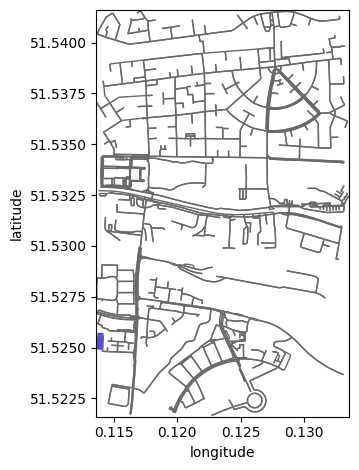

In [67]:
BOX_WIDTH, BOX_HEIGHT = 0.02, 0.02
for i in range(len(tags)):
    # Retrieve nodes and edges
    nodes, edges = ox.graph_to_gdfs(graph)
    
    # Get place boundary related to the place name as a geodataframe
    area = ox.geocode_to_gdf("Kings Cross, London", which_result=1)

    fig, ax = plt.subplots(locations[0][2])

    # Plot the footprint
    area.plot(ax=ax, facecolor="white")

    # Plot street edges
    edges.plot(ax=ax, linewidth=1, edgecolor="dimgray")
    
    north, south, west, east = assess.get_box(locations[0][0], locations[0][1], BOX_HEIGHT, BOX_WIDTH)
    ax.set_xlim([west, east])
    ax.set_ylim([south, north])
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")

    # Plot all POIs
    pois.plot(ax=ax, color="blue", alpha=0.7, markersize=10)
    plt.tight_layout()

In [ ]:
# PCA

In [ ]:
# Cross correlation of features

In [ ]:
# Autocorrelation of features

## Question 3. Addressing a Property Price Prediction Question

For your final tick, we will be asking you to make house price predictions for a given location, date and property type in the UK. You will provide a function that takes input a latitude and longitude as well as the `property_type` (either type" of property (either `F` - flat, `S` - semidetached, `D` - detached, `T` - terraced or `O` other). Create this function in the `address.py` file, for example in the form,

```
def predict_price(latitude, longitude, date, property_type):
    """Price prediction for UK housing."""
    pass
```

We suggest that you use the following approach when building your prediction.

1. Select a bounding box around the housing location in latitude and longitude.
2. Select a data range around the prediction date.
3. Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.
4. Train a linear model on the data set you have created.
5. Validate the quality of the model.
6. Provide a prediction of the price from the model, warning appropriately if your validation indicates the quality of the model is poor.

Please note that the quality of predictions is not the main focus of the assignment - we expect to see models that output reasonable predictions and have positive R^2's, but you should not spend too much time on increasing the model's accuracy.

The knowledge you need to do a first pass through this question will have been taught by end of lab session four (7th November 2023). You will likely want to review your answer as part of *refactoring* your code shortly before hand in.



## Large Language Models

If you used LLMs to generate or fix code in this assignment (recommended), briefly summarise the process and prompts you used. What do you think of the integration of LLMs in the data science pipeline?

```GIVE YOUR WRITTEN ANSWER HERE```

### FAQs

- Why is my connection to the AWS server intermittent?

If you are using Google Colab, online notebooks may throttle your code or time you out. Local Python code is recommended for tasks for large data management in the database.

- Why do SQL queries take a long time?

Some queries legitimately take a long time, even when done right. We suggest indexing your tables to speed up queries over your database. You can index tables by different columns depending on the queries you want to perform. For example, indexing the tables by `postcode` could speed up the join in Task D. More information regarding indexing in MariaDB is available [here](https://mariadb.com/kb/en/getting-started-with-indexes/).

You may also want to consider creating single or multi-column indices on coordinates, or any other properties you use to select data, if that step is taking a long time.

If your new queries seem stuck, try running `SHOW FULL PROCESSLIST`, and `KILL` any stuck processes.

- Why are table populating processes taking so long?

Again populating the database can take long. However, be careful if you are indexing the tables. You should populate data before indexing. Insert operations are impacted by indexes as they are updated with each new row inserted into the table.

- Some other questions are answered in [this reddit forum](https://www.reddit.com/r/CST_ADS/) or [this doc](https://docs.google.com/document/d/1GfDROyUW8HVs2eyxmJzKrYGRdVyUiVXzPcDfwOO8wX0/edit?usp=sharing). Feel free to also ask about anything that comes up.